<a href="https://colab.research.google.com/github/Alex112525/Neural-Networks-with-TensorFlow/blob/main/KerasTunner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip 

--2023-02-24 00:19:23--  https://storage.googleapis.com/platzi-tf2/sign-language-img.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24265584 (23M) [application/zip]
Saving to: ‘sign-language-img.zip’

sign-language-img.z 100%[===================>]  23.14M  15.8MB/s    in 1.5s    

2023-02-24 00:19:25 (15.8 MB/s) - ‘sign-language-img.zip’ saved [24265584/24265584]



In [2]:
!unzip -q /content/sign-language-img.zip -d Dataset

Keras Tuner is a library that helps to optimize hyperparameters for machine learning models built with TensorFlow and Keras. It allows you to define a search space of hyperparameters and uses various techniques to search through the space to find the optimal set of hyperparameters that can lead to better model performance. Keras Tuner can be used for various types of machine learning models, including image classification, text classification, and time-series forecasting.

In [3]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt
from keras import models, layers, optimizers, regularizers

#Import Dataset

In [5]:
train_dir = "/content/Dataset/Test"
test_dir = "/content/Dataset/Train"

Create Datagenerators

In [6]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.3)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28, 28),
    batch_size = 128,
    shuffle=True,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "training"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    shuffle=True,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    shuffle=True,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 7172 images belonging to 24 classes.
Found 8226 images belonging to 24 classes.
Found 27455 images belonging to 24 classes.


Load class names

In [8]:
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)
print(class_names," Classes:", n_classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']  Classes: 24


In [9]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

Test Generators

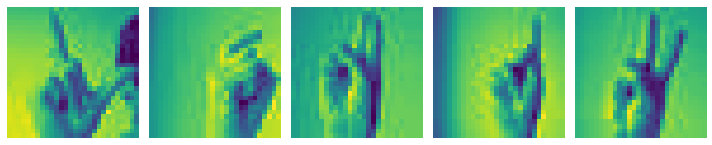

In [10]:
sample_training_images, _= next(train_generator)
plotImages(sample_training_images[:5])

Function to build all different models

In [11]:
def build_models(hp):
  model = models.Sequential()
  model.add(layers.Input(shape = (28, 28, 1)))
  model.add(layers.Conv2D(64, 3, activation="relu"))
  model.add(layers.MaxPool2D((2, 2)))
  model.add(layers.Conv2D(32, 3, activation="relu"))
  model.add(layers.MaxPool2D((2, 2)))
  model.add(layers.Flatten())

  hp_units = hp.Int("units", min_value = 64, max_value = 512, step = 64)

  model.add(layers.Dense(units=hp_units, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(n_classes, activation="softmax"))

  hp_learning_rate = hp.Choice('learning_rate', values = [15e-4, 1e-3])

  model.compile(optimizer = optimizers.Adam(learning_rate=hp_learning_rate),
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  return model

This code creates an instance of a KerasTuner Hyperband object named "tuner". The Hyperband algorithm is a hyperparameter optimization technique that uses a combination of random search and early stopping.

 * The **"build_models"** argument specifies a function that creates a Keras model to be trained and evaluated.
 *The **"objective"** argument specifies the metric to be used to evaluate the performance of the models.
 *The **"max_epochs"** argument specifies the maximum number of epochs to train each model.
 *The **"factor"** argument specifies the reduction factor for the number of models to keep in each round of the hyperband algorithm. 
 *Finally, the **"directory"** and **"project_name"** arguments specify the directory where the hyperparameter search results will be stored.

In [12]:
tuner = kt.Hyperband(
    build_models,
    objective = "val_accuracy",
    max_epochs = 12,
    factor = 3,
    directory = "models/",
    project_name = "tunner"
)

In [13]:
class TrainingCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get("accuracy") > .90:
      print('Finished epoch {} with 95% accuracy, stop training'.format(epoch)) 
      self.model.stop_training = True

stop_training_callback = TrainingCallback()

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, mode="auto")

This code is using the KerasTuner library to perform hyperparameter tuning for a deep learning model.

In [15]:
tuner.search(train_generator,
             epochs=10,
             callbacks=[stop_training_callback, early_stop],
             validation_data=validation_generator)

Trial 30 Complete [00h 03m 51s]
val_accuracy: 0.6780938506126404

Best val_accuracy So Far: 0.7120106816291809
Total elapsed time: 00h 44m 08s


The line **best_hps = tuner.get_best_hyperparameters(num_trials =1)[0]** retrieves the best hyperparameters found during the Keras Tuner search process. It returns the best set of hyperparameters as a HyperParameters object that can be used to create and compile a model for further training and evaluation. The argument num_trials specifies how many of the top performing hyperparameters to retrieve. In this case, num_trials is set to 1, so the function returns only the single best set of hyperparameters.

In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get("units"))
print(best_hps.get("learning_rate"))

384
0.0015


#Build and train the best model

In [17]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_3 (Dense)             (None, 384)              

In [18]:
times = 20
history_hypermodel = hypermodel.fit(
    train_generator,
    epochs = times,
    callbacks = [stop_training_callback],
    validation_data = validation_generator
)

Epoch 1/20
57/57 [==============================] - 17s 290ms/step - loss: 3.1641 - accuracy: 0.0668 - val_loss: 3.1521 - val_accuracy: 0.0694
Epoch 2/20
57/57 [==============================] - 15s 265ms/step - loss: 2.8193 - accuracy: 0.1603 - val_loss: 2.5699 - val_accuracy: 0.2124
Epoch 3/20
57/57 [==============================] - 16s 284ms/step - loss: 2.1727 - accuracy: 0.3277 - val_loss: 1.8794 - val_accuracy: 0.4320
Epoch 4/20
57/57 [==============================] - 17s 291ms/step - loss: 1.5933 - accuracy: 0.4826 - val_loss: 1.5390 - val_accuracy: 0.5208
Epoch 5/20
57/57 [==============================] - 20s 355ms/step - loss: 1.2649 - accuracy: 0.5739 - val_loss: 1.3036 - val_accuracy: 0.6072
Epoch 6/20
57/57 [==============================] - 16s 278ms/step - loss: 0.9823 - accuracy: 0.6605 - val_loss: 1.2553 - val_accuracy: 0.6317
Epoch 7/20
57/57 [==============================] - 18s 313ms/step - loss: 0.7981 - accuracy: 0.7269 - val_loss: 1.1585 - val_accuracy: 0.6747

#Results

In [21]:
def results_visualization(history, epoch):
  epochs = [i for i in range(epoch)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16,9)

  ax[0].plot(epochs, train_acc, "go-",label = "Train accuracy")
  ax[0].plot(epochs, val_acc, "ro-",label = "Validation accuracy")
  ax[0].set_title("Accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-",label = "Train loss")
  ax[1].plot(epochs, val_loss, "ro-",label = "Validation loss")
  ax[1].set_title("Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show() 

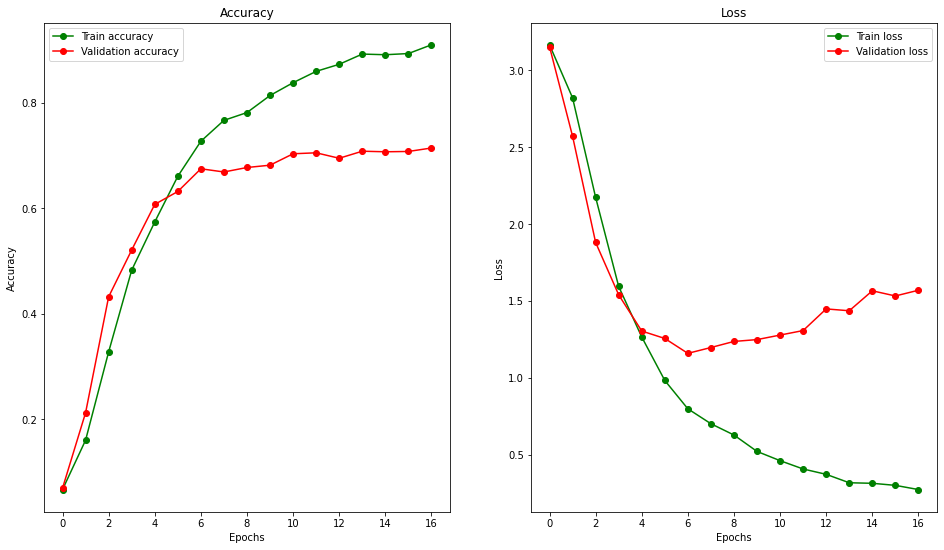

In [22]:
results_visualization(history_hypermodel, 17)